In [1]:
# 용도
# 원본에서 노이즈 제거하여 원복 복원
# 노이즈에 강건한 모델 만들기

In [2]:
import tensorflow as tf
from keras import optimizers
import glob
import numpy as np
np.set_printoptions(threshold= np.inf) #...없이 출력하기
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, MaxPooling2D, UpSampling2D, 
                          Flatten, Input, BatchNormalization) 
np.random.seed(111)

Using TensorFlow backend.


In [3]:
# tep-by-Step으로 아래와 같이 정리할 수 있다.
# 1. Training 및 Test 데이터셋을 불러오고, 정규화한다.
# 2. 모델을 정의한다.
# 3. 손실 함수와 Optimizer 정의한다.
# 4. Training 데이터를 사용하여 신경망을 학습한다.
# 5. Test 데이터를 사용하여 신경망이 잘 훈련 했는지를 검사한다.

In [10]:
#1.
train = glob.glob('denoising-dirty-documents/train/*png') # glob는 같은 위치부터 시작
train_cleaned = glob.glob('denoising-dirty-documents/train_cleaned/*png')
test = glob.glob('denoising-dirty-documents/test/*png')

print("Total number of images in the training set: ", len(train)) # Training set 144장
print("Total number of cleaned images found: ", len(train_cleaned))       # Train cleaned set 144장
print("Total number of samples in the test set: ", len(test))     # Test set 72장

epochs= 40
batch_size = 8

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


In [5]:
# Load train images and train labels
X = [] # 인풋에 들어가는 image 리스트 : Train data
X_target = [] # 아웃풋에 들어가는 image 리스트 : Train_cleaned data

for img in train:
    img = load_img(img, grayscale=True, target_size=(420,540)) # 흑백으로 바꿈
    img = img_to_array(img).astype('float32')/255 # 채널은 1이지만 값은 아직 255임
    X.append(img)
X= np.array(X)

for img in train_cleaned:
    img = load_img(img, grayscale=True, target_size=(420,540))
    img = img_to_array(img).astype('float32') / 255
    X_target.append(img)
X_target = np.array(X_target)

print("Size of X : ", X.shape) # Size of X : (144,420,540,1) , Training set 144장
print("Size of X_target : ", X_target.shape) # Size of Y : (144,420,540,1) , Train cleaned 144장


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of X_target :  (144, 420, 540, 1)


In [6]:
# Load test images
test_list = []

for img in test:
    img = load_img(img, grayscale=True, target_size=(420,540))
    img = img_to_array(img).astype('float32') / 255
    test_list.append(img)

In [7]:
# 2. define model

def build_autoencoder():
    # 입력 정의
    input_img = Input(shape=(420,540,1), name='image_input')
    
    # encoder
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
              padding='same')(input_img)
    #배치정규화: 층마다 출력값을 배치 단위로 정규화(데이터 분포를 0,1로)
    x = BatchNormalization()(x)
    #  <효과>
    #1) 학습 속도가 개선된다 (학습률을 높게 설정할 수 있기 때문)
    #2) 가중치 초깃값 선택의 의존성이 적어진다 (학습을 할 때마다 출력값을 정규화하기 때문)
    #3) 과적합(overfitting) 위험을 줄일 수 있다 (드롭아웃 같은 기법 대체 가능)
    #4) Gradient Vanishing 문제 해결
    
    x = MaxPooling2D((2, 2))(x) # (32, 105,135)?
    x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', 
               padding='same')(x) # 
    x = MaxPooling2D(2, 2)(x) # (64, 52, 67)?
    
    # decoder
    x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
               padding='same')(x)
    x = UpSampling2D((2, 2))(x) # 4배 : 각 픽셀 주위에 zero_padding 후 컨블루션 연산
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
              padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', kernel_initializer='he_normal',
               padding='same')(x)
    # model
    autoencoder = Model(inputs= input_img, outputs= x) # 위의 식과 연결됨
    return autoencoder

In [8]:
# 3. Define optimizer and loss function
model = build_autoencoder()
model.compile(optimizer=optimizers.Adam(), loss='MSE')

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# 4. Train your model
history = model.fit(X, X_target, epochs= epochs, batch_size= batch_size)

Epoch 1/40
144/144 [==============================] - 7s 52ms/step - loss: 0.0681
Epoch 2/40
144/144 [==============================] - 6s 40ms/step - loss: 0.0303
Epoch 3/40
144/144 [==============================] - 6s 41ms/step - loss: 0.0231
Epoch 4/40
144/144 [==============================] - 6s 41ms/step - loss: 0.0191
Epoch 5/40
144/144 [==============================] - 6s 41ms/step - loss: 0.0167
Epoch 6/40
144/144 [==============================] - 6s 41ms/step - loss: 0.0150
Epoch 7/40
144/144 [==============================] - 6s 41ms/step - loss: 0.0137
Epoch 8/40
144/144 [==============================] - 6s 42ms/step - loss: 0.0127
Epoch 9/40
144/144 [==============================] - 6s 41ms/step - loss: 0.0119
Epoch 10/40
144/144 [==============================] - 6s 42ms/step - loss: 0.0112
Epoch 11/40
144/144 [==============================] - 6s 42ms/step - loss: 0.0105
Epoch 12/40
144/144 [==============================] - 6s 42ms/step - loss: 0.0100
Epoch 13/40
1

In [16]:
# 5. Predict test images(Get denoised version of test images)
predicted_list= []
for img in test_list:
    img = np.reshape(img,(1,420,540,1))
    predicted = np.squeeze(model.predict(img, batch_size= 1)) # squeeze: 쓸데없는 차원 축소([] 제거)
    predicted_list.append(predicted)

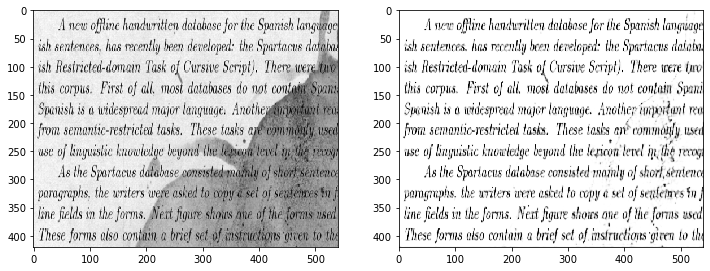

In [17]:
# Plot original denoised version of test image
_, ax = plt.subplots(1, 2, figsize=(12, 9.338))
ax[0].imshow(np.squeeze(test_list[0]), cmap='gray') # 1열은 원본 이미지
ax[1].imshow(np.squeeze(predicted_list[0].astype('float32')), cmap='gray') # 2열은 잡음제거한 이미지
plt.show()

In [18]:
# 5. Predict test images(Get denoised version of test images)

prepredicted_list= []
for img in predicted_list:
    img = np.reshape(img,(1,420,540,1))
    prepredicted = np.squeeze(model.predict(img, batch_size= 1)) # squeeze: 쓸데없는 차원 축소([] 제거)
    prepredicted_list.append(prepredicted)

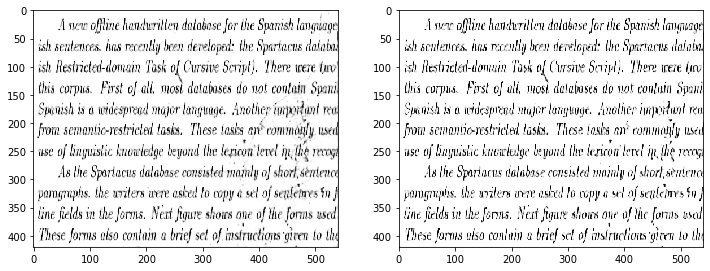

In [20]:
# Plot original denoised version of test image
_, ax = plt.subplots(1, 2, figsize=(12, 9.338))
ax[0].imshow(np.squeeze(predicted_list[0]), cmap='gray') # 1열은 원본 이미지
ax[1].imshow(np.squeeze(prepredicted_list[0].astype('float32')), cmap='gray') # 2열은 잡음제거한 이미지
plt.show()